# Import Library and Load Data

## Import Library

In [ ]:
!pip install segmentation-models-pytorch

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 5.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.3/121.3 kB 6.9 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16424 sha256=38ea0d1d3c75356407023fa5d79c47499790658129b0edc2bb5b80bffb35a6c2
  Stored in directory: /root/.cache/pip/wheels/8b/6f/9b/231a832f811ab6ebb1b32455b177ffc6b8b1cd8de19de70c09
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60944 sha256=2d5f80fe506bd4ee449b65ef310e3a8e41f89deb8b2196bec3caba019651711d
  Stored in directory: /root/.cache/pip/wheels/5f/5b/96/fd94bc35962d7c6b699e8814db545155ac91d2b95785e1b035
Successfully built efficientnet-pytorch pretrainedmodels


In [ ]:
from google.colab import drive
import os
import pandas as pd
import matplotlib.pyplot as plt
import zipfile
from collections import Counter

import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
import numpy as np
import shutil

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
import time
import copy
from torch.cuda.amp import GradScaler, autocast
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import random
from PIL import Image
import segmentation_models_pytorch as smp
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision.models import efficientnet_b3

## Load Data

In [ ]:
# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Path ke file ZIP dan folder tujuan
zip_path = '/content/drive/MyDrive/Freelance/16_01_2025/merge.zip'  # Ganti dengan lokasi file ZIP Anda
extract_path = 'dataset/'  # Folder tujuan setelah unzip

# Membuka dan mengekstrak file ZIP
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print(f"Dataset berhasil diekstrak ke: {extract_path}")

# Melihat isi folder setelah ekstraksi
extracted_files = os.listdir(extract_path)
print("Isi folder dataset:")
print(extracted_files)

Dataset berhasil diekstrak ke: dataset/
Isi folder dataset:
['merge']


# Merge DATASET (YOLO)

In [ ]:
DATASET_PATH = "/content/dataset/merge"
# Define class names
class_names = ['hole', 'line', 'stain', 'thread']

# Path to the 'labels' folder
labels_path = f'{DATASET_PATH}/labels'

In [ ]:
# Initialize a dictionary to count images for each class
class_counts = {class_name: 0 for class_name in class_names}

# Iterate through label files
for label_file in os.listdir(labels_path):
    if label_file.endswith('.txt'):  # Ensure only .txt files are processed
        file_path = os.path.join(labels_path, label_file)
        with open(file_path, 'r') as file:
            lines = file.readlines()
            # Track unique classes present in the current image
            image_classes = set()
            for line in lines:
                class_id = int(line.split()[0])  # The first value in each line is the class ID
                image_classes.add(class_id)
            # Update the counts for each class present in this image
            for class_id in image_classes:
                class_counts[class_names[class_id]] += 1

# Print the total images per class
for class_name, count in class_counts.items():
    print(f"Class '{class_name}': {count} images")

Class 'hole': 2557 images
Class 'line': 1261 images
Class 'stain': 2972 images
Class 'thread': 4180 images


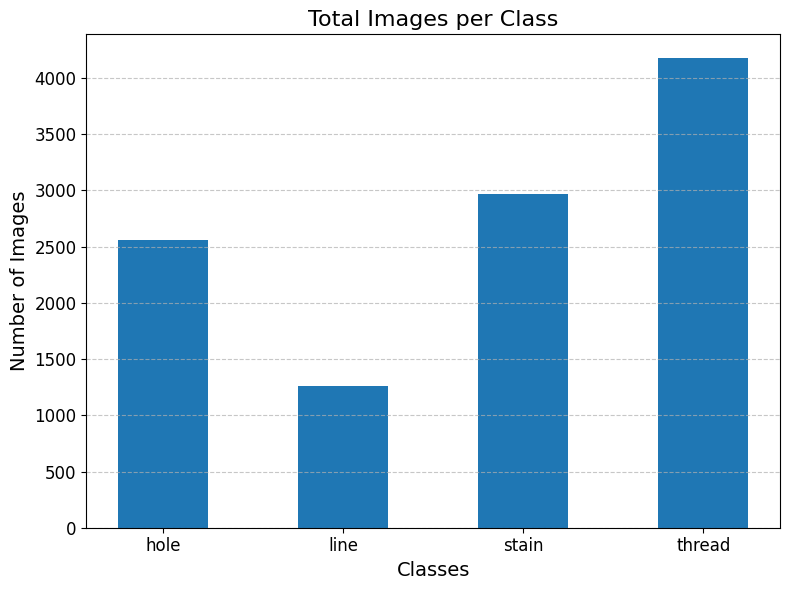

In [ ]:
# Prepare data for visualization
classes = list(class_counts.keys())
counts = list(class_counts.values())

# Create the bar chart
plt.figure(figsize=(8, 6))
plt.bar(classes, counts, width=0.5)
plt.title('Total Images per Class', fontsize=16)
plt.xlabel('Classes', fontsize=14)
plt.ylabel('Number of Images', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()

## Data Preprocessing

In [ ]:
# Path to your dataset
images_path = os.path.join(DATASET_PATH, 'images')
labels_path = os.path.join(DATASET_PATH, 'labels')

In [ ]:
# Output paths for train, val, and test
output_path = 'data_train'
train_ratio = 0.7
val_ratio = 0.2
test_ratio = 0.1

In [ ]:
# Create train, val, and test folders
for split in ['train', 'val', 'test']:
    os.makedirs(os.path.join(output_path, split, 'images'), exist_ok=True)
    os.makedirs(os.path.join(output_path, split, 'labels'), exist_ok=True)

# Get all image filenames
image_files = [f for f in os.listdir(images_path) if f.endswith('.jpg') or f.endswith('.png')]
random.shuffle(image_files)

# Calculate number of files for each subset
train_count = int(len(image_files) * train_ratio)
val_count = int(len(image_files) * val_ratio)

# Split data
train_files = image_files[:train_count]
val_files = image_files[train_count:train_count + val_count]
test_files = image_files[train_count + val_count:]

# Function to move files
def move_files(file_list, split):
    for file_name in file_list:
        # Move image
        shutil.copy2(os.path.join(images_path, file_name),
                     os.path.join(output_path, split, 'images', file_name))

        # Move corresponding label
        label_file = file_name.replace('.jpg', '.txt').replace('.png', '.txt')
        if os.path.exists(os.path.join(labels_path, label_file)):
            shutil.copy2(os.path.join(labels_path, label_file),
                         os.path.join(output_path, split, 'labels', label_file))

# Move files to respective folders
move_files(train_files, 'train')
move_files(val_files, 'val')
move_files(test_files, 'test')

print("Dataset has been split into train, val, and test!")

Dataset has been split into train, val, and test!


In [ ]:
train_labels_path = '/content/data_train/train/labels'
train_images_path = '/content/data_train/train/images'

# Class distribution (update based on your data)
class_counts = {'hole': 2557, 'line': 1261, 'stain': 2972, 'thread': 4180}
target_count = max(class_counts.values())  # Balance to the largest class

# Oversample minority classes
for class_name, count in class_counts.items():
    if count < target_count:
        # Find all label files for this class
        label_files = [f for f in os.listdir(train_labels_path) if class_name in f]
        additional_needed = target_count - count

        for _ in range(additional_needed):
            label_file = random.choice(label_files)
            image_file = label_file.replace('.txt', '.jpg')

            # Copy image and label
            shutil.copy2(os.path.join(train_labels_path, label_file),
                         os.path.join(train_labels_path, f'copy_{label_file}'))
            shutil.copy2(os.path.join(train_images_path, image_file),
                         os.path.join(train_images_path, f'copy_{image_file}'))

print("Oversampling completed!")

Oversampling completed!


In [ ]:
class_counts = [2557, 1261, 2972, 4180]
total_images = sum(class_counts)
class_weights = [total_images / count for count in class_counts]
normalized_weights = np.array(class_weights) / sum(class_weights)
print("Normalized Class Weights:", normalized_weights)

Normalized Class Weights: [0.22223004 0.45062825 0.19119859 0.13594311]


In [ ]:
!touch data_train/data.yaml

### YoloV5 CSPDarknet53

In [ ]:
!git clone https://github.com/ultralytics/yolov5.git
%cd yolov5

Cloning into 'yolov5'...
remote: Enumerating objects: 17265, done.
remote: Counting objects: 100% (105/105), done.
remote: Compressing objects: 100% (91/91), done.
remote: Total 17265 (delta 57), reused 14 (delta 14), pack-reused 17160 (from 4)
Receiving objects: 100% (17265/17265), 16.01 MiB | 16.78 MiB/s, done.
Resolving deltas: 100% (11799/11799), done.
/content/yolov5


In [ ]:
!touch models/cspdarknet53_yolov5s.yaml

In [ ]:
import torch
print(torch.cuda.is_available())

True


In [ ]:
!python train.py \
    --img 416 \
    --batch 64 \
    --epochs 10 \
    --data "../data_train/data.yaml" \
    --cfg models/cspdarknet53_yolov5s.yaml \
    --weights yolov5s.pt \
    --hyp data/hyps/hyp.yaml \
    --device 0

wandb: WARNING ⚠️ wandb is deprecated and will be removed in a future release. See supported integrations at https://github.com/ultralytics/yolov5#integrations.
2025-01-19 07:47:18.101302: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-19 07:47:18.124647: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-19 07:47:18.131737: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice: (30 second timeout) 3
wandb: You chose "Don't visualize my results"
t

# Merge Dataset (CNN)

In [ ]:
DATASET_PATH = "/content/dataset/merge"
# Define class names
class_names = ['hole', 'line', 'stain', 'thread']

# Path to the 'labels' folder
labels_path = f'{DATASET_PATH}/labels'

In [ ]:
# Initialize a dictionary to count images for each class
class_counts = {class_name: 0 for class_name in class_names}

# Iterate through label files
for label_file in os.listdir(labels_path):
    if label_file.endswith('.txt'):  # Ensure only .txt files are processed
        file_path = os.path.join(labels_path, label_file)
        with open(file_path, 'r') as file:
            lines = file.readlines()
            # Track unique classes present in the current image
            image_classes = set()
            for line in lines:
                class_id = int(line.split()[0])  # The first value in each line is the class ID
                image_classes.add(class_id)
            # Update the counts for each class present in this image
            for class_id in image_classes:
                class_counts[class_names[class_id]] += 1

# Print the total images per class
for class_name, count in class_counts.items():
    print(f"Class '{class_name}': {count} images")

Class 'hole': 2557 images
Class 'line': 1261 images
Class 'stain': 2972 images
Class 'thread': 4180 images


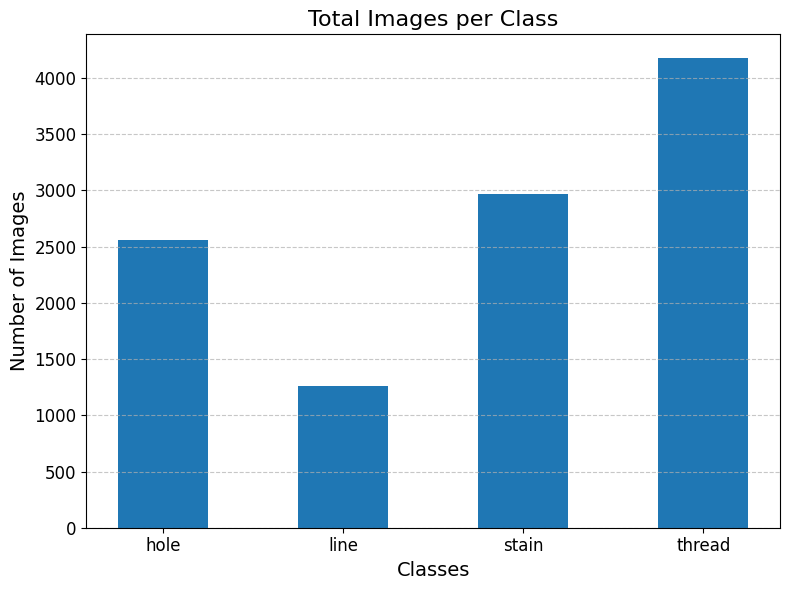

In [ ]:
# Prepare data for visualization
classes = list(class_counts.keys())
counts = list(class_counts.values())

# Create the bar chart
plt.figure(figsize=(8, 6))
plt.bar(classes, counts, width=0.5)
plt.title('Total Images per Class', fontsize=16)
plt.xlabel('Classes', fontsize=14)
plt.ylabel('Number of Images', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()

## Data Preparation

In [ ]:
images_path = os.path.join(DATASET_PATH, "images")
labels_path = os.path.join(DATASET_PATH, "labels")
output_path = "dataset_cnn"  # New dataset for CNN

# Create train and test folders
os.makedirs(os.path.join(output_path, "train"), exist_ok=True)
os.makedirs(os.path.join(output_path, "test"), exist_ok=True)

In [ ]:
# Define train-test split ratio
train_ratio = 0.8

# Get all image files
image_files = [f for f in os.listdir(images_path) if f.endswith(".jpg")]

# Process images and labels
classwise_images = {}  # To store images grouped by class
for img_file in image_files:
    label_file = img_file.replace(".jpg", ".txt")
    label_path = os.path.join(labels_path, label_file)

    # Read the label file only if it's not empty
    if os.path.exists(label_path) and os.path.getsize(label_path) > 0:  # Check for file size
        with open(label_path, "r") as f:
            lines = f.readlines()
            # Take the first class ID (handle cases with multiple objects)
            if lines:  # Proceed if lines is not empty
                class_id = lines[0].split()[0].strip()
            else:
                print(f"Warning: Label file '{label_file}' is empty. Skipping this image.")
                continue  # Skip to the next image

        # Group by class
        if class_id not in classwise_images:
            classwise_images[class_id] = []
        classwise_images[class_id].append(img_file)

# Create class-wise folders and move files
for class_id, images in classwise_images.items():
    # Create class folders
    train_class_path = os.path.join(output_path, "train", f"class_{class_id}")
    test_class_path = os.path.join(output_path, "test", f"class_{class_id}")
    os.makedirs(train_class_path, exist_ok=True)
    os.makedirs(test_class_path, exist_ok=True)

    # Split into train and test
    split_index = int(len(images) * train_ratio)
    train_images = images[:split_index]
    test_images = images[split_index:]

    # Move images
    for img in train_images:
        shutil.copy2(os.path.join(images_path, img), os.path.join(train_class_path, img))
    for img in test_images:
        shutil.copy2(os.path.join(images_path, img), os.path.join(test_class_path, img))

print("Dataset conversion completed!")

Dataset conversion completed!


## EDA

In [ ]:
# Paths to the dataset
dataset_path = "dataset_cnn"  # Replace with your dataset folder
train_path = os.path.join(dataset_path, "train")
test_path = os.path.join(dataset_path, "test")

# Helper function: Count images in each class
def count_images_per_class(base_path):
    class_counts = {}
    for class_folder in os.listdir(base_path):
        class_folder_path = os.path.join(base_path, class_folder)
        if os.path.isdir(class_folder_path):
            num_images = len([f for f in os.listdir(class_folder_path) if f.endswith(('.jpg', '.png'))])
            class_counts[class_folder] = num_images
    return class_counts

Train Class Distribution: {'class_2': 1715, 'class_1': 994, 'class_0': 1499, 'class_3': 3068}
Test Class Distribution: {'class_2': 429, 'class_1': 249, 'class_0': 375, 'class_3': 768}


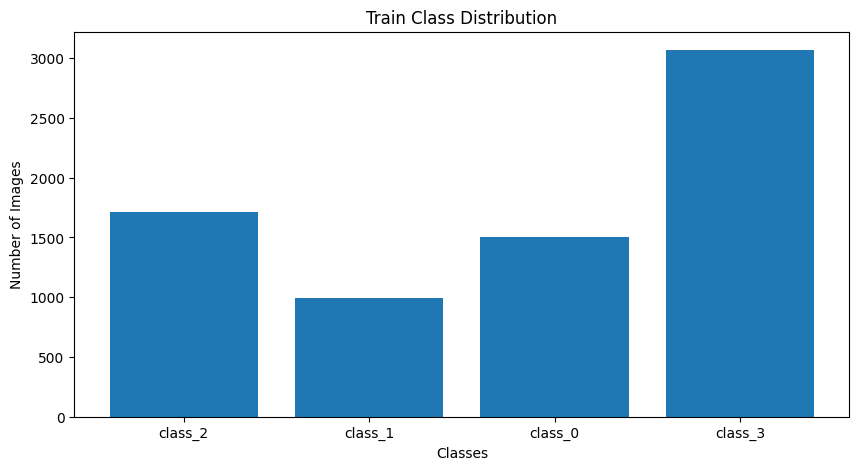

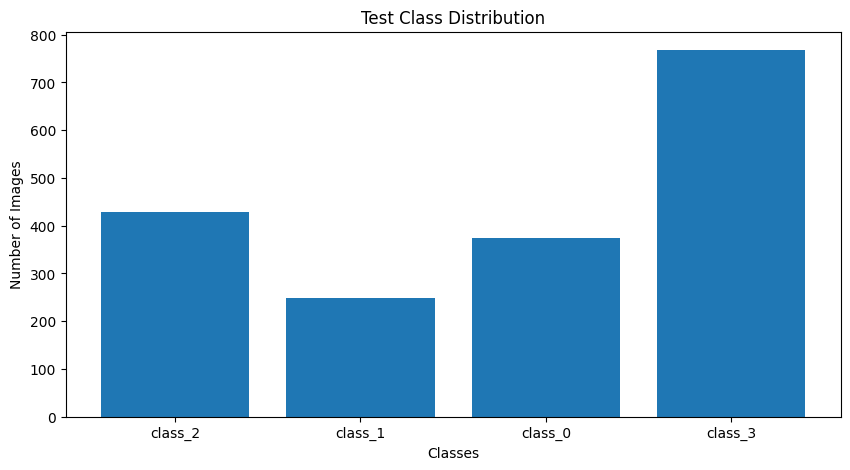

In [ ]:
# 1. Analyze Class Distribution
train_counts = count_images_per_class(train_path)
test_counts = count_images_per_class(test_path)

print("Train Class Distribution:", train_counts)
print("Test Class Distribution:", test_counts)

# Plot Class Distribution
def plot_class_distribution(counts, title):
    classes = list(counts.keys())
    values = list(counts.values())
    plt.figure(figsize=(10, 5))
    plt.bar(classes, values)
    plt.title(title)
    plt.xlabel("Classes")
    plt.ylabel("Number of Images")
    plt.show()

plot_class_distribution(train_counts, "Train Class Distribution")
plot_class_distribution(test_counts, "Test Class Distribution")


Displaying Example Images from Train Set:


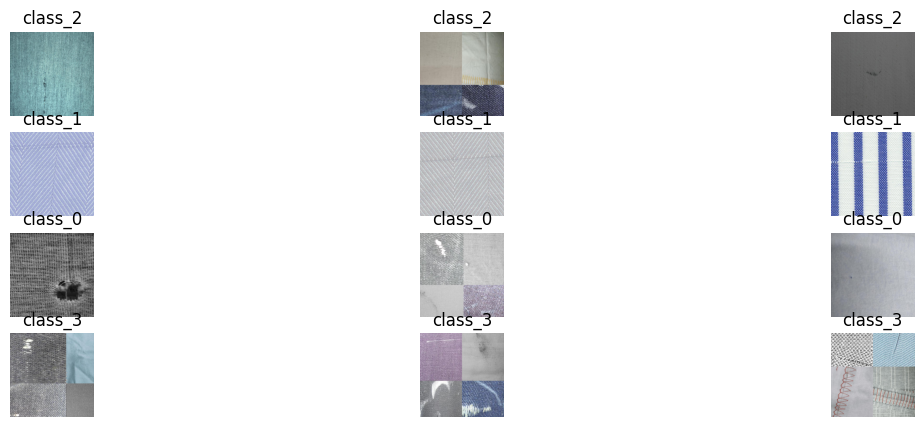

In [ ]:
# 2. Display Example Images from Each Class
def show_example_images(base_path, num_examples=3):
    plt.figure(figsize=(15, 5))
    for i, class_folder in enumerate(os.listdir(base_path)):
        class_folder_path = os.path.join(base_path, class_folder)
        if os.path.isdir(class_folder_path):
            images = [f for f in os.listdir(class_folder_path) if f.endswith(('.jpg', '.png'))][:num_examples]
            for j, img_name in enumerate(images):
                img_path = os.path.join(class_folder_path, img_name)
                img = Image.open(img_path)
                plt.subplot(len(os.listdir(base_path)), num_examples, i * num_examples + j + 1)
                plt.imshow(img)
                plt.axis("off")
                plt.title(class_folder)
    plt.show()

print("\nDisplaying Example Images from Train Set:")
show_example_images(train_path)


Analyzing Image Properties from Train Set:

Unique Image Dimensions (Width x Height):
(640, 640): 7276 images


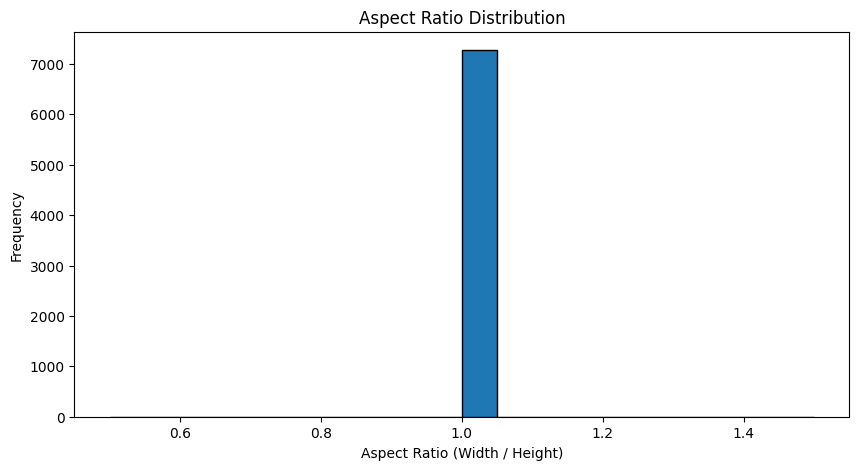

In [ ]:
# 3. Analyze Image Properties
def analyze_image_properties(base_path):
    dimensions = []
    for class_folder in os.listdir(base_path):
        class_folder_path = os.path.join(base_path, class_folder)
        if os.path.isdir(class_folder_path):
            images = [f for f in os.listdir(class_folder_path) if f.endswith(('.jpg', '.png'))]
            for img_name in images:
                img_path = os.path.join(class_folder_path, img_name)
                img = Image.open(img_path)
                dimensions.append(img.size)  # (width, height)

    # Count unique dimensions
    dim_counter = Counter(dimensions)
    print(f"\nUnique Image Dimensions (Width x Height):")
    for dim, count in dim_counter.items():
        print(f"{dim}: {count} images")

    # Plot aspect ratio distribution
    aspect_ratios = [w / h for w, h in dimensions]
    plt.figure(figsize=(10, 5))
    plt.hist(aspect_ratios, bins=20, edgecolor="black")
    plt.title("Aspect Ratio Distribution")
    plt.xlabel("Aspect Ratio (Width / Height)")
    plt.ylabel("Frequency")
    plt.show()

print("\nAnalyzing Image Properties from Train Set:")
analyze_image_properties(train_path)

## Handle Imbalancing

In [ ]:
# Paths
train_path = "dataset_cnn/train"

# Define augmentations
augment = transforms.Compose([
    transforms.RandomRotation(15),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1)
])

# Oversample and augment minority classes
target_count = max([len(os.listdir(os.path.join(train_path, cls))) for cls in os.listdir(train_path)])

for cls in os.listdir(train_path):
    class_path = os.path.join(train_path, cls)
    images = os.listdir(class_path)
    while len(images) < target_count:
        img_name = random.choice(images)
        img_path = os.path.join(class_path, img_name)
        img = Image.open(img_path)
        img_aug = augment(img)
        img_aug.save(os.path.join(class_path, f"aug_{len(images)}.jpg"))
        images.append(f"aug_{len(images)}.jpg")

print("Oversampling and augmentation completed!")

Oversampling and augmentation completed!


## Resizing and Normalize Images

In [ ]:
# Define preprocessing transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to 224x224
    transforms.ToTensor(),         # Convert image to tensor
    transforms.Normalize([0.5], [0.5])  # Normalize to range [-1, 1]
])

# Apply transformations to train and test sets
train_dataset = datasets.ImageFolder("dataset_cnn/train", transform=transform)
test_dataset = datasets.ImageFolder("dataset_cnn/test", transform=transform)

# Create DataLoaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

print("Data preprocessing completed!")

Data preprocessing completed!


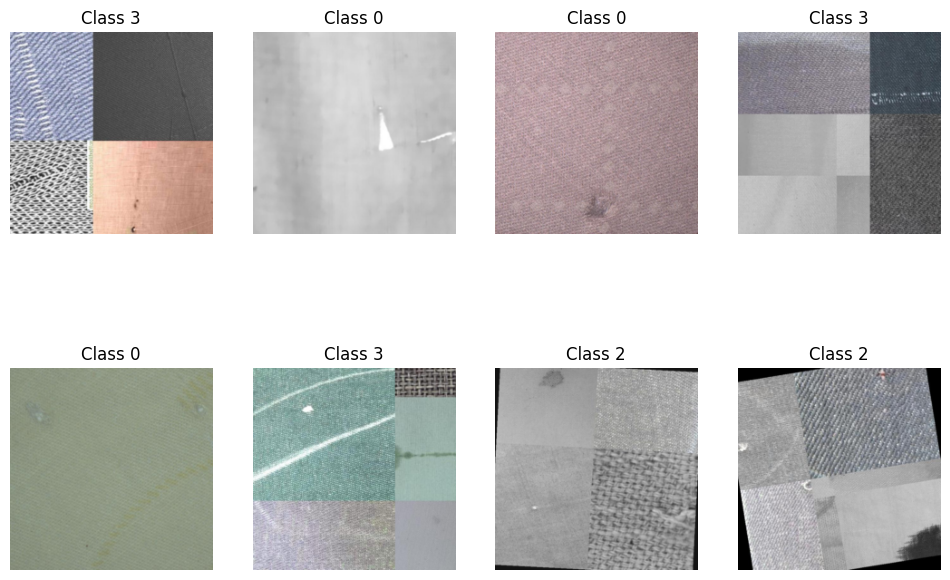

In [ ]:
# Visualize some preprocessed images
data_iter = iter(train_loader)
images, labels = next(data_iter)

# Denormalize and display images
def denormalize(tensor):
    return tensor * 0.5 + 0.5  # Reverse normalization to range [0, 1]

plt.figure(figsize=(12, 8))
for i in range(8):
    plt.subplot(2, 4, i+1)
    img = denormalize(images[i]).permute(1, 2, 0)  # Convert to HWC format
    plt.imshow(img.numpy())
    plt.title(f"Class {labels[i].item()}")
    plt.axis("off")
plt.show()

Train Class Distribution: {'class_2': 3068, 'class_1': 3068, 'class_0': 3068, 'class_3': 3068}


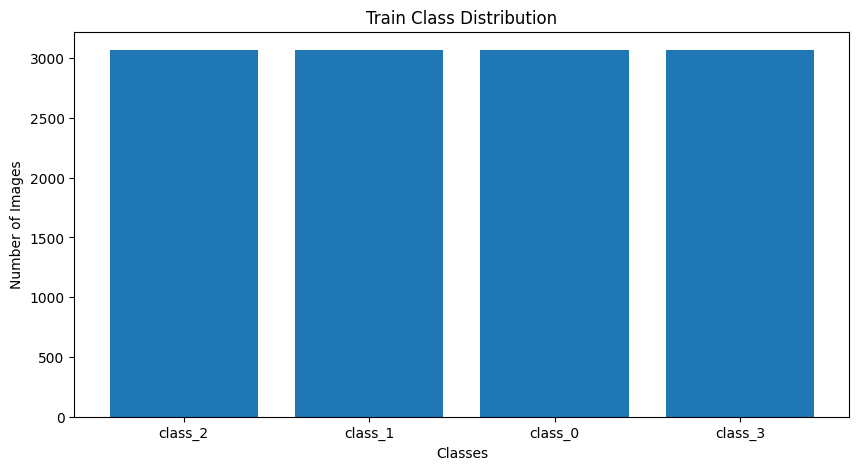

In [ ]:
# Class Distribution
train_counts = count_images_per_class(train_path)

print("Train Class Distribution:", train_counts)

# Plot Class Distribution
def plot_class_distribution(counts, title):
    classes = list(counts.keys())
    values = list(counts.values())
    plt.figure(figsize=(10, 5))
    plt.bar(classes, values)
    plt.title(title)
    plt.xlabel("Classes")
    plt.ylabel("Number of Images")
    plt.show()

plot_class_distribution(train_counts, "Train Class Distribution")

## Train CNN Models

### Simple CNN

In [ ]:
class DefectClassifierCNN(nn.Module):
    def __init__(self, num_classes=4):
        super(DefectClassifierCNN, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)  # Input: (3, 224, 224), Output: (32, 224, 224)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)  # Output: (64, 112, 112)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)  # Output: (128, 56, 56)

        # Pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)  # Downsamples feature maps by half

        # Fully connected layers (input size will be calculated dynamically)
        self.fc1 = None  # Placeholder, initialized later
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, num_classes)

        # Dropout
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))

        # Dynamically initialize the first FC layer
        if self.fc1 is None:
            self.fc1 = nn.Linear(x.view(x.size(0), -1).size(1), 256).to(x.device)

        x = torch.flatten(x, 1)  # Flatten feature maps into a 1D vector
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)  # Output logits for each class

        return x

In [ ]:
# Hyperparameters
batch_size = 32
learning_rate = 0.001
epochs = 20
num_classes = 4
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data preprocessing
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])  # Normalize to [-1, 1]
])

# Load datasets
train_dataset = datasets.ImageFolder("dataset_cnn/train", transform=transform)
test_dataset = datasets.ImageFolder("dataset_cnn/test", transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Initialize model
model = DefectClassifierCNN(num_classes=num_classes).to(device)

In [ ]:
# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
for epoch in range(epochs):
    model.train()
    train_loss = 0
    all_labels = []
    all_predictions = []

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Track loss
        train_loss += loss.item()

        # Track predictions and labels
        _, predicted = torch.max(outputs, 1)
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    # Calculate metrics
    train_accuracy = (np.array(all_predictions) == np.array(all_labels)).mean() * 100
    train_precision = precision_score(all_labels, all_predictions, average="weighted")
    train_recall = recall_score(all_labels, all_predictions, average="weighted")
    train_f1 = f1_score(all_labels, all_predictions, average="weighted")

    print(f"Epoch [{epoch+1}/{epochs}]")
    print(f"Loss: {train_loss/len(train_loader):.4f} | Accuracy: {train_accuracy:.2f}%")
    print(f"Precision: {train_precision:.4f} | Recall: {train_recall:.4f} | F1 Score: {train_f1:.4f}")

Epoch [1/20]
Loss: 1.1758 | Accuracy: 45.64%
Precision: 0.4379 | Recall: 0.4564 | F1 Score: 0.4250
Epoch [2/20]
Loss: 1.0447 | Accuracy: 54.73%
Precision: 0.5429 | Recall: 0.5473 | F1 Score: 0.5291
Epoch [3/20]
Loss: 0.9746 | Accuracy: 58.96%
Precision: 0.5880 | Recall: 0.5896 | F1 Score: 0.5799
Epoch [4/20]
Loss: 0.9378 | Accuracy: 61.32%
Precision: 0.6158 | Recall: 0.6132 | F1 Score: 0.6043
Epoch [5/20]
Loss: 0.9115 | Accuracy: 63.01%
Precision: 0.6346 | Recall: 0.6301 | F1 Score: 0.6217
Epoch [6/20]
Loss: 0.8796 | Accuracy: 64.37%
Precision: 0.6494 | Recall: 0.6437 | F1 Score: 0.6348
Epoch [7/20]
Loss: 0.8628 | Accuracy: 65.17%
Precision: 0.6581 | Recall: 0.6517 | F1 Score: 0.6424
Epoch [8/20]
Loss: 0.8401 | Accuracy: 66.29%
Precision: 0.6711 | Recall: 0.6629 | F1 Score: 0.6540
Epoch [9/20]
Loss: 0.8296 | Accuracy: 66.63%
Precision: 0.6744 | Recall: 0.6663 | F1 Score: 0.6577
Epoch [10/20]
Loss: 0.8100 | Accuracy: 67.72%
Precision: 0.6837 | Recall: 0.6772 | F1 Score: 0.6695
Epoch [11

### Pre-Trained Model ResNet18

In [ ]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data preprocessing
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])  # Normalize to [-1, 1]
])

# Load datasets
train_dataset = datasets.ImageFolder("dataset_cnn/train", transform=transform)
test_dataset = datasets.ImageFolder("dataset_cnn/test", transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
# Load pretrained ResNet18
model = models.resnet18(pretrained=True)

# Modify the last fully connected layer
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 4)  # 4 classes
model = model.to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:01<00:00, 44.9MB/s]


In [ ]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 20

for epoch in range(epochs):
    model.train()
    train_loss = 0
    all_labels = []
    all_predictions = []

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Track loss
        train_loss += loss.item()

        # Track predictions and labels
        _, predicted = torch.max(outputs, 1)
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    # Calculate metrics
    train_accuracy = (np.array(all_predictions) == np.array(all_labels)).mean() * 100
    train_precision = precision_score(all_labels, all_predictions, average="weighted")
    train_recall = recall_score(all_labels, all_predictions, average="weighted")
    train_f1 = f1_score(all_labels, all_predictions, average="weighted")

    print(f"Epoch [{epoch+1}/{epochs}]")
    print(f"Loss: {train_loss/len(train_loader):.4f} | Accuracy: {train_accuracy:.2f}%")
    print(f"Precision: {train_precision:.4f} | Recall: {train_recall:.4f} | F1 Score: {train_f1:.4f}")

Epoch [1/20]
Loss: 0.8576 | Accuracy: 66.18%
Precision: 0.6620 | Recall: 0.6618 | F1 Score: 0.6554
Epoch [2/20]
Loss: 0.6669 | Accuracy: 74.37%
Precision: 0.7459 | Recall: 0.7437 | F1 Score: 0.7405
Epoch [3/20]
Loss: 0.5810 | Accuracy: 78.23%
Precision: 0.7858 | Recall: 0.7823 | F1 Score: 0.7804
Epoch [4/20]
Loss: 0.5130 | Accuracy: 80.39%
Precision: 0.8072 | Recall: 0.8039 | F1 Score: 0.8022
Epoch [5/20]
Loss: 0.4604 | Accuracy: 82.73%
Precision: 0.8322 | Recall: 0.8273 | F1 Score: 0.8265
Epoch [6/20]
Loss: 0.4259 | Accuracy: 83.74%
Precision: 0.8422 | Recall: 0.8374 | F1 Score: 0.8363
Epoch [7/20]
Loss: 0.3950 | Accuracy: 85.10%
Precision: 0.8559 | Recall: 0.8510 | F1 Score: 0.8504
Epoch [8/20]
Loss: 0.3635 | Accuracy: 86.43%
Precision: 0.8695 | Recall: 0.8643 | F1 Score: 0.8637
Epoch [9/20]
Loss: 0.3238 | Accuracy: 87.52%
Precision: 0.8795 | Recall: 0.8752 | F1 Score: 0.8746
Epoch [10/20]
Loss: 0.2979 | Accuracy: 88.57%
Precision: 0.8899 | Recall: 0.8857 | F1 Score: 0.8853
Epoch [11

In [ ]:
# Testing loop
model.eval()
test_loss = 0
all_labels = []
all_predictions = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Track loss
        test_loss += loss.item()

        # Track predictions and labels
        _, predicted = torch.max(outputs, 1)
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate metrics
test_accuracy = (np.array(all_predictions) == np.array(all_labels)).mean() * 100
test_precision = precision_score(all_labels, all_predictions, average="weighted")
test_recall = recall_score(all_labels, all_predictions, average="weighted")
test_f1 = f1_score(all_labels, all_predictions, average="weighted")

print(f"Test Loss: {test_loss/len(test_loader):.4f} | Test Accuracy: {test_accuracy:.2f}%")
print(f"Precision: {test_precision:.4f} | Recall: {test_recall:.4f} | F1 Score: {test_f1:.4f}")

Test Loss: 0.8849 | Test Accuracy: 75.95%
Precision: 0.7622 | Recall: 0.7595 | F1 Score: 0.7564


### Fine-Tunning Pre-Trained Model ResNet18

In [ ]:
# Data Augmentation
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

# Load datasets
train_dataset = datasets.ImageFolder("dataset_cnn/train", transform=transform)
test_dataset = datasets.ImageFolder("dataset_cnn/test", transform=transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
]))

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Optimizer with Weight Decay
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)

# Learning Rate Scheduler
scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.1)

In [ ]:
# Training Loop with Metrics and Early Stopping
best_loss = float('inf')
patience = 5
counter = 0

for epoch in range(epochs):
    model.train()
    train_loss = 0

    all_predictions = []
    all_labels = []

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        # Track predictions and labels for metrics
        _, predicted = torch.max(outputs, 1)
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    # Calculate metrics
    train_accuracy = (np.array(all_predictions) == np.array(all_labels)).mean() * 100
    train_precision = precision_score(all_labels, all_predictions, average="weighted")
    train_recall = recall_score(all_labels, all_predictions, average="weighted")
    train_f1 = f1_score(all_labels, all_predictions, average="weighted")

    print(f"Epoch [{epoch+1}/{epochs}]")
    print(f"Loss: {train_loss/len(train_loader):.4f} | Accuracy: {train_accuracy:.2f}%")
    print(f"Precision: {train_precision:.4f} | Recall: {train_recall:.4f} | F1 Score: {train_f1:.4f}")

    # Early stopping
    scheduler.step(train_loss)
    if train_loss < best_loss:
        best_loss = train_loss
        counter = 0
        torch.save(model.state_dict(), "best_model.pth")
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping triggered.")
            break

In [ ]:
# Evaluate the model on the test set
model.eval()
test_loss = 0

all_predictions = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        test_loss += loss.item()

        # Track predictions and labels for metrics
        _, predicted = torch.max(outputs, 1)
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate metrics
test_accuracy = (np.array(all_predictions) == np.array(all_labels)).mean() * 100
test_precision = precision_score(all_labels, all_predictions, average="weighted")
test_recall = recall_score(all_labels, all_predictions, average="weighted")
test_f1 = f1_score(all_labels, all_predictions, average="weighted")

print(f"Test Loss: {test_loss/len(test_loader):.4f}")
print(f"Test Accuracy: {test_accuracy:.2f}%")
print(f"Test Precision: {test_precision:.4f} | Test Recall: {test_recall:.4f} | Test F1 Score: {test_f1:.4f}")

Test Loss: 0.7010
Test Accuracy: 77.98%
Test Precision: 0.7798 | Test Recall: 0.7798 | Test F1 Score: 0.7750


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
<ipython-input-63-6b539521cc49>:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions

Test Loss: 0.7010
Test Accuracy: 77.98%
Test Precision: 0.7798 | Test Recall: 0.7798 | Test F1 Score: 0.7750


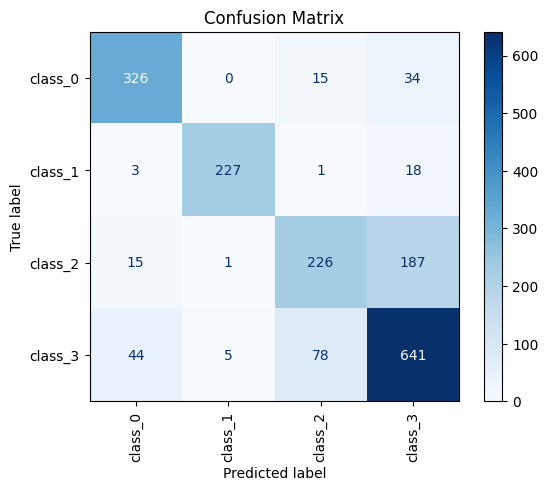

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

# Load the trained model
model = models.resnet18(pretrained=False)  # Replace with ResNet50 if used
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 4)  # Adjust the final layer for 4 classes
model.load_state_dict(torch.load("best_model.pth"))  # Load the saved model
model = model.to(device)
model.eval()  # Set the model to evaluation mode

# Evaluate the model on the test set
test_loss = 0
all_predictions = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        # Store predictions and labels
        _, predicted = torch.max(outputs, 1)
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate metrics
test_accuracy = (np.array(all_predictions) == np.array(all_labels)).mean() * 100
test_precision = precision_score(all_labels, all_predictions, average="weighted")
test_recall = recall_score(all_labels, all_predictions, average="weighted")
test_f1 = f1_score(all_labels, all_predictions, average="weighted")

# Print metrics
print(f"Test Loss: {test_loss/len(test_loader):.4f}")
print(f"Test Accuracy: {test_accuracy:.2f}%")
print(f"Test Precision: {test_precision:.4f} | Test Recall: {test_recall:.4f} | Test F1 Score: {test_f1:.4f}")

# Generate confusion matrix
cm = confusion_matrix(all_labels, all_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_dataset.classes)
disp.plot(cmap="Blues", xticks_rotation="vertical")
plt.title("Confusion Matrix")
plt.show()

### Pre-Trained Model ResNet50

In [ ]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
# Data augmentation for training set
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),             # Resize images to 224x224
    transforms.RandomHorizontalFlip(p=0.5),    # Randomly flip images horizontally
    transforms.RandomRotation(15),             # Rotate images up to 15 degrees
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Brightness/contrast adjustments
    transforms.ToTensor(),                     # Convert to tensor
    transforms.Normalize([0.5], [0.5])         # Normalize to [-1, 1]
])

# Data transformation for test set
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

# Load datasets
train_dataset = datasets.ImageFolder("dataset_cnn/train", transform=train_transform)
test_dataset = datasets.ImageFolder("dataset_cnn/test", transform=test_transform)

# Create data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
# Load pretrained ResNet50
model = models.resnet50(pretrained=True)

# Modify the final fully connected layer for 4 classes
num_features = model.fc.in_features
model.fc = nn.Sequential(
    nn.Linear(num_features, 256),  # Add an intermediate layer
    nn.ReLU(),
    nn.Dropout(0.5),               # Dropout for regularization
    nn.Linear(256, 4)              # Output layer for 4 classes
)
model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 172MB/s]


In [ ]:
# Learning rate scheduler
from torch.optim.lr_scheduler import ReduceLROnPlateau
scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.1)

# Early stopping parameters
best_loss = float('inf')
patience = 5
counter = 0

# Training loop
epochs = 20
for epoch in range(epochs):
    model.train()
    train_loss = 0

    all_predictions = []
    all_labels = []

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        # Track predictions and labels for metrics
        _, predicted = torch.max(outputs, 1)
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    # Calculate metrics
    train_accuracy = (np.array(all_predictions) == np.array(all_labels)).mean() * 100
    train_precision = precision_score(all_labels, all_predictions, average="weighted")
    train_recall = recall_score(all_labels, all_predictions, average="weighted")
    train_f1 = f1_score(all_labels, all_predictions, average="weighted")

    print(f"Epoch [{epoch+1}/{epochs}]")
    print(f"Loss: {train_loss/len(train_loader):.4f} | Accuracy: {train_accuracy:.2f}%")
    print(f"Precision: {train_precision:.4f} | Recall: {train_recall:.4f} | F1 Score: {train_f1:.4f}")

    # Early stopping
    scheduler.step(train_loss)
    if train_loss < best_loss:
        best_loss = train_loss
        counter = 0
        torch.save(model.state_dict(), "best_model.pth")
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping triggered.")
            break

Epoch [1/20]
Loss: 0.6783 | Accuracy: 73.72%
Precision: 0.7392 | Recall: 0.7372 | F1 Score: 0.7347
Epoch [2/20]
Loss: 0.4764 | Accuracy: 81.82%
Precision: 0.8222 | Recall: 0.8182 | F1 Score: 0.8172
Epoch [3/20]
Loss: 0.4074 | Accuracy: 84.45%
Precision: 0.8502 | Recall: 0.8445 | F1 Score: 0.8440
Epoch [4/20]
Loss: 0.3731 | Accuracy: 85.90%
Precision: 0.8648 | Recall: 0.8590 | F1 Score: 0.8584
Epoch [5/20]
Loss: 0.3302 | Accuracy: 87.24%
Precision: 0.8780 | Recall: 0.8724 | F1 Score: 0.8718
Epoch [6/20]
Loss: 0.3114 | Accuracy: 88.05%
Precision: 0.8862 | Recall: 0.8805 | F1 Score: 0.8802
Epoch [7/20]
Loss: 0.2988 | Accuracy: 88.29%
Precision: 0.8876 | Recall: 0.8829 | F1 Score: 0.8825
Epoch [8/20]
Loss: 0.2893 | Accuracy: 88.69%
Precision: 0.8910 | Recall: 0.8869 | F1 Score: 0.8867
Epoch [9/20]
Loss: 0.2715 | Accuracy: 89.64%
Precision: 0.9002 | Recall: 0.8964 | F1 Score: 0.8962
Epoch [10/20]
Loss: 0.2544 | Accuracy: 90.08%
Precision: 0.9039 | Recall: 0.9008 | F1 Score: 0.9007
Epoch [11

<ipython-input-24-e93bdb650b4f>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pth"))


Test Loss: 0.6364
Test Accuracy: 80.23%
Test Precision: 0.7995 | Test Recall: 0.8023 | Test F1 Score: 0.7995


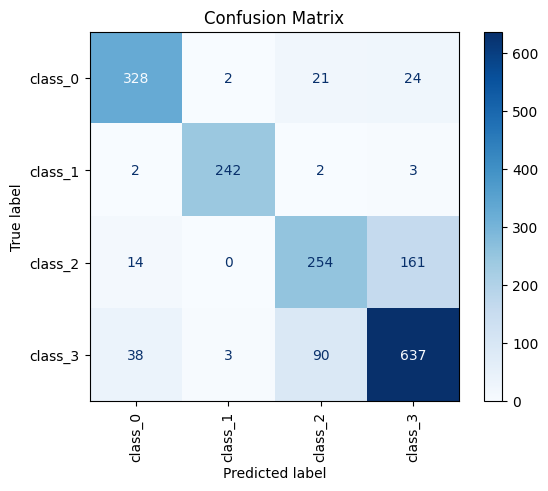

In [ ]:
# Load the best model
model.load_state_dict(torch.load("best_model.pth"))
model.eval()

# Test the model
test_loss = 0
all_predictions = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        # Track predictions and labels for metrics
        _, predicted = torch.max(outputs, 1)
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate metrics
test_accuracy = (np.array(all_predictions) == np.array(all_labels)).mean() * 100
test_precision = precision_score(all_labels, all_predictions, average="weighted")
test_recall = recall_score(all_labels, all_predictions, average="weighted")
test_f1 = f1_score(all_labels, all_predictions, average="weighted")

# Print metrics
print(f"Test Loss: {test_loss/len(test_loader):.4f}")
print(f"Test Accuracy: {test_accuracy:.2f}%")
print(f"Test Precision: {test_precision:.4f} | Test Recall: {test_recall:.4f} | Test F1 Score: {test_f1:.4f}")

# Confusion matrix
cm = confusion_matrix(all_labels, all_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=train_dataset.classes)
disp.plot(cmap="Blues", xticks_rotation="vertical")
plt.title("Confusion Matrix")
plt.show()

### Pre-trained Model EfficientNet-B0

In [ ]:
# Data augmentation for training set
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

# Data transformation for test set
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

# Load datasets
train_dataset = datasets.ImageFolder("dataset_cnn/train", transform=train_transform)
test_dataset = datasets.ImageFolder("dataset_cnn/test", transform=test_transform)

# Data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
# Load pretrained EfficientNet-B0
model = efficientnet_b0(pretrained=True)

# Modify the classifier
num_features = model.classifier[1].in_features
model.classifier = nn.Sequential(
    nn.Linear(num_features, 256),  # Add an intermediate layer
    nn.ReLU(),
    nn.Dropout(0.5),               # Regularization
    nn.Linear(256, 4)              # Output layer for 4 classes
)
model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)

In [ ]:
from torch.optim.lr_scheduler import CosineAnnealingLR

# Learning rate scheduler
scheduler = CosineAnnealingLR(optimizer, T_max=10)

# Early stopping parameters
best_loss = float('inf')
patience = 5
counter = 0

# Training loop
epochs = 20
for epoch in range(epochs):
    model.train()
    train_loss = 0

    all_predictions = []
    all_labels = []

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        # Track predictions and labels for metrics
        _, predicted = torch.max(outputs, 1)
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    # Calculate metrics
    train_accuracy = (np.array(all_predictions) == np.array(all_labels)).mean() * 100
    train_precision = precision_score(all_labels, all_predictions, average="weighted")
    train_recall = recall_score(all_labels, all_predictions, average="weighted")
    train_f1 = f1_score(all_labels, all_predictions, average="weighted")

    print(f"Epoch [{epoch+1}/{epochs}]")
    print(f"Loss: {train_loss/len(train_loader):.4f} | Accuracy: {train_accuracy:.2f}%")
    print(f"Precision: {train_precision:.4f} | Recall: {train_recall:.4f} | F1 Score: {train_f1:.4f}")

    # Early stopping
    scheduler.step(train_loss)
    if train_loss < best_loss:
        best_loss = train_loss
        counter = 0
        torch.save(model.state_dict(), "best_model_efficientnet_b0.pth")
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping triggered.")
            break

Epoch [1/20]
Loss: 0.7808 | Accuracy: 69.33%
Precision: 0.6903 | Recall: 0.6933 | F1 Score: 0.6896


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch [2/20]
Loss: 0.4805 | Accuracy: 81.54%
Precision: 0.8181 | Recall: 0.8154 | F1 Score: 0.8140


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch [3/20]
Loss: 0.3786 | Accuracy: 85.28%
Precision: 0.8567 | Recall: 0.8528 | F1 Score: 0.8522


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch [4/20]
Loss: 0.3393 | Accuracy: 86.38%
Precision: 0.8679 | Recall: 0.8638 | F1 Score: 0.8633


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch [5/20]
Loss: 0.3111 | Accuracy: 87.82%
Precision: 0.8830 | Recall: 0.8782 | F1 Score: 0.8773


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch [6/20]
Loss: 0.3319 | Accuracy: 87.21%
Precision: 0.8758 | Recall: 0.8721 | F1 Score: 0.8718


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch [7/20]
Loss: 0.2769 | Accuracy: 89.29%
Precision: 0.8966 | Recall: 0.8929 | F1 Score: 0.8926


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch [8/20]
Loss: 0.2606 | Accuracy: 89.86%
Precision: 0.9019 | Recall: 0.8986 | F1 Score: 0.8984


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch [9/20]
Loss: 0.2697 | Accuracy: 89.41%
Precision: 0.8972 | Recall: 0.8941 | F1 Score: 0.8940


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch [10/20]
Loss: 0.2469 | Accuracy: 90.38%
Precision: 0.9062 | Recall: 0.9038 | F1 Score: 0.9036


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch [11/20]
Loss: 0.2069 | Accuracy: 91.92%
Precision: 0.9213 | Recall: 0.9192 | F1 Score: 0.9192


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch [12/20]
Loss: 0.2107 | Accuracy: 91.73%
Precision: 0.9191 | Recall: 0.9173 | F1 Score: 0.9173


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch [13/20]
Loss: 0.2009 | Accuracy: 92.10%
Precision: 0.9223 | Recall: 0.9210 | F1 Score: 0.9209


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch [14/20]
Loss: 0.1864 | Accuracy: 92.81%
Precision: 0.9291 | Recall: 0.9281 | F1 Score: 0.9281


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch [15/20]
Loss: 0.1463 | Accuracy: 94.31%
Precision: 0.9441 | Recall: 0.9431 | F1 Score: 0.9431


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch [16/20]
Loss: 0.1604 | Accuracy: 93.98%
Precision: 0.9408 | Recall: 0.9398 | F1 Score: 0.9398


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch [17/20]
Loss: 0.1522 | Accuracy: 93.95%
Precision: 0.9402 | Recall: 0.9395 | F1 Score: 0.9394


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch [18/20]
Loss: 0.1483 | Accuracy: 94.26%
Precision: 0.9433 | Recall: 0.9426 | F1 Score: 0.9426


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch [19/20]
Loss: 0.1347 | Accuracy: 94.68%
Precision: 0.9474 | Recall: 0.9468 | F1 Score: 0.9468


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch [20/20]
Loss: 0.1158 | Accuracy: 95.43%
Precision: 0.9553 | Recall: 0.9543 | F1 Score: 0.9543


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


<ipython-input-29-24aba85581ef>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model_efficientnet_b0.pth"))


Test Loss: 0.7221
Test Accuracy: 80.34%
Test Precision: 0.8036 | Test Recall: 0.8034 | Test F1 Score: 0.7992


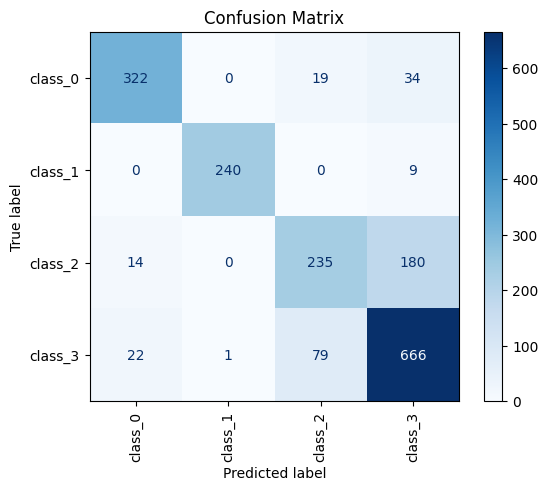

In [ ]:
# Load the best model
model.load_state_dict(torch.load("best_model_efficientnet_b0.pth"))
model.eval()

# Test the model
test_loss = 0
all_predictions = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        # Track predictions and labels for metrics
        _, predicted = torch.max(outputs, 1)
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate metrics
test_accuracy = (np.array(all_predictions) == np.array(all_labels)).mean() * 100
test_precision = precision_score(all_labels, all_predictions, average="weighted")
test_recall = recall_score(all_labels, all_predictions, average="weighted")
test_f1 = f1_score(all_labels, all_predictions, average="weighted")

# Print metrics
print(f"Test Loss: {test_loss/len(test_loader):.4f}")
print(f"Test Accuracy: {test_accuracy:.2f}%")
print(f"Test Precision: {test_precision:.4f} | Test Recall: {test_recall:.4f} | Test F1 Score: {test_f1:.4f}")

# Confusion matrix
cm = confusion_matrix(all_labels, all_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=train_dataset.classes)
disp.plot(cmap="Blues", xticks_rotation="vertical")
plt.title("Confusion Matrix")
plt.show()

### EfficientNet-B3

In [ ]:
# Load pretrained EfficientNet-B3
model = efficientnet_b3(pretrained=True)

# Modify the classifier
num_features = model.classifier[1].in_features
model.classifier = nn.Sequential(
    nn.Linear(num_features, 256),  # Add an intermediate layer
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(256, 4)  # 4 classes
)
model = model.to(device)

# Loss function with label smoothing
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

# Optimizer and scheduler
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.0005, steps_per_epoch=len(train_loader), epochs=20)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B3_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b3_rwightman-b3899882.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b3_rwightman-b3899882.pth
100%|██████████| 47.2M/47.2M [00:00<00:00, 127MB/s]


In [ ]:
best_loss = float('inf')
patience = 5
counter = 0
epochs = 20

for epoch in range(epochs):
    model.train()
    train_loss = 0

    all_predictions = []
    all_labels = []

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        # Update scheduler
        scheduler.step()

        # Track predictions and labels for metrics
        _, predicted = torch.max(outputs, 1)
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    # Calculate metrics
    train_accuracy = (np.array(all_predictions) == np.array(all_labels)).mean() * 100
    train_precision = precision_score(all_labels, all_predictions, average="weighted")
    train_recall = recall_score(all_labels, all_predictions, average="weighted")
    train_f1 = f1_score(all_labels, all_predictions, average="weighted")

    print(f"Epoch [{epoch+1}/{epochs}]")
    print(f"Loss: {train_loss/len(train_loader):.4f} | Accuracy: {train_accuracy:.2f}%")
    print(f"Precision: {train_precision:.4f} | Recall: {train_recall:.4f} | F1 Score: {train_f1:.4f}")

    # Save the best model
    if train_loss < best_loss:
        best_loss = train_loss
        counter = 0
        torch.save(model.state_dict(), "best_model_efficientnet_b3.pth")
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping triggered.")
            break

Epoch [1/20]
Loss: 1.1367 | Accuracy: 57.42%
Precision: 0.5844 | Recall: 0.5742 | F1 Score: 0.5719
Epoch [2/20]
Loss: 0.7653 | Accuracy: 77.82%
Precision: 0.7798 | Recall: 0.7782 | F1 Score: 0.7756
Epoch [3/20]
Loss: 0.6606 | Accuracy: 83.80%
Precision: 0.8414 | Recall: 0.8380 | F1 Score: 0.8371
Epoch [4/20]
Loss: 0.6156 | Accuracy: 86.53%
Precision: 0.8696 | Recall: 0.8653 | F1 Score: 0.8650
Epoch [5/20]
Loss: 0.5909 | Accuracy: 87.79%
Precision: 0.8814 | Recall: 0.8779 | F1 Score: 0.8776
Epoch [6/20]
Loss: 0.5729 | Accuracy: 88.97%
Precision: 0.8933 | Recall: 0.8897 | F1 Score: 0.8897
Epoch [7/20]
Loss: 0.5490 | Accuracy: 90.28%
Precision: 0.9054 | Recall: 0.9028 | F1 Score: 0.9026
Epoch [8/20]
Loss: 0.5279 | Accuracy: 91.22%
Precision: 0.9139 | Recall: 0.9122 | F1 Score: 0.9122
Epoch [9/20]
Loss: 0.5091 | Accuracy: 92.20%
Precision: 0.9237 | Recall: 0.9220 | F1 Score: 0.9220
Epoch [10/20]
Loss: 0.4876 | Accuracy: 93.18%
Precision: 0.9326 | Recall: 0.9318 | F1 Score: 0.9318
Epoch [11

In [ ]:
from torchvision.transforms import functional as F

# Test-Time Augmentation (TTA)
tta_transforms = [
    lambda x: x,  # Original (No Augmentation)
    lambda x: F.hflip(x),  # Horizontal Flip
    lambda x: F.rotate(x, angle=15),  # Rotation by 15 degrees
]

def tta_predict(model, dataloader, tta_transforms):
    model.eval()
    all_predictions = []
    all_labels = []
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            tta_preds = []
            for t in tta_transforms:
                # Apply each TTA transform on every image in the batch
                aug_images = torch.stack([F.to_tensor(t(F.to_pil_image(img.cpu()))) for img in images])
                aug_images = aug_images.to(device)
                outputs = model(aug_images)
                probs = torch.softmax(outputs, dim=1)
                tta_preds.append(probs.cpu().numpy())
            # Average predictions across all TTA transforms
            averaged_preds = np.mean(tta_preds, axis=0)
            all_predictions.extend(np.argmax(averaged_preds, axis=1))
            all_labels.extend(labels.cpu().numpy())
    return all_predictions, all_labels

Test Accuracy: 72.43%
Test Precision: 0.7268 | Test Recall: 0.7243 | Test F1 Score: 0.7207


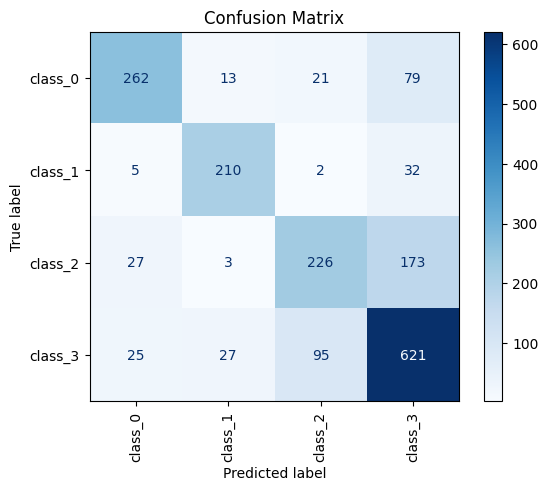

In [ ]:
# Perform TTA and calculate metrics
all_predictions, all_labels = tta_predict(model, test_loader, tta_transforms)
test_accuracy = (np.array(all_predictions) == np.array(all_labels)).mean() * 100
test_precision = precision_score(all_labels, all_predictions, average="weighted")
test_recall = recall_score(all_labels, all_predictions, average="weighted")
test_f1 = f1_score(all_labels, all_predictions, average="weighted")

print(f"Test Accuracy: {test_accuracy:.2f}%")
print(f"Test Precision: {test_precision:.4f} | Test Recall: {test_recall:.4f} | Test F1 Score: {test_f1:.4f}")

# Confusion Matrix
cm = confusion_matrix(all_labels, all_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=train_dataset.classes)
disp.plot(cmap="Blues", xticks_rotation="vertical")
plt.title("Confusion Matrix")
plt.show()


<ipython-input-38-11c1dcb06a1e>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/content/best_model_efficientnet_b3.pth"))


Test Loss: 0.8120
Test Accuracy: 79.85%
Test Precision: 0.7978 | Test Recall: 0.7985 | Test F1 Score: 0.7965


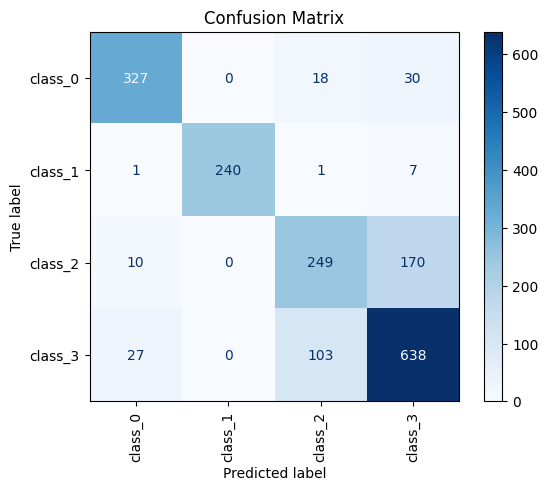

In [ ]:
# Load the best model
model.load_state_dict(torch.load("/content/best_model_efficientnet_b3.pth"))
model.eval()

# Test the model
test_loss = 0
all_predictions = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        # Track predictions and labels for metrics
        _, predicted = torch.max(outputs, 1)
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate metrics
test_accuracy = (np.array(all_predictions) == np.array(all_labels)).mean() * 100
test_precision = precision_score(all_labels, all_predictions, average="weighted")
test_recall = recall_score(all_labels, all_predictions, average="weighted")
test_f1 = f1_score(all_labels, all_predictions, average="weighted")

# Print metrics
print(f"Test Loss: {test_loss/len(test_loader):.4f}")
print(f"Test Accuracy: {test_accuracy:.2f}%")
print(f"Test Precision: {test_precision:.4f} | Test Recall: {test_recall:.4f} | Test F1 Score: {test_f1:.4f}")

# Confusion matrix
cm = confusion_matrix(all_labels, all_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=train_dataset.classes)
disp.plot(cmap="Blues", xticks_rotation="vertical")
plt.title("Confusion Matrix")
plt.show()